In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import time
import math

In [0]:
#model-specific Parameters
model = 'GBM'

params = []     
if (model == 'GBM'):
    
    sig = 0.25;
    params.append(sig);
    
elif (model == 'VG'):
    
    sig = 0.3
    nu = 0.5
    theta = -0.4
    #
    params.append(sig);
    params.append(nu);
    params.append(theta);
    
elif (model == 'Heston'):
    
    kappa = 2.0
    theta = 0.05
    sig = 0.30
    rho = -0.70
    v0 = 0.04
    #
    params.append(kappa)
    params.append(theta)
    params.append(sig)
    params.append(rho)
    params.append(v0)
    
    
### For VGSA and VGSSD, I am not sure if the parameters are reasonable.    
elif (model == 'VGSA'):
    sig    = 0.25 
    nu     = 0.5
    theta  = 0.05
   
    kappa  = 2.0
    eta    = 0.2
    ld     = 0.1
    
    params.append(sig)
    params.append(nu)
    params.append(theta)
    params.append(kappa)
    params.append(eta)
    params.append(ld)

elif  (model == 'VGSSD'):
    sig    = 0.25 
    nu     = 0.5
    theta  = 0.05
    gamma  = 1.0
    
    params.append(sig)
    params.append(nu)
    params.append(theta)
    params.append(gamma)

In [0]:
def generic_CF(u, params , S0, r, q, T, model):
    '''
    Get Characteristic function

    '''
    
    if (model == 'GBM'):
        
        sig = params[0]
        mu = np.log(S0) + (r-q-sig**2/2)*T
        a = sig*np.sqrt(T)
        phi = np.exp(1j*mu*u-(a*u)**2/2)
        
    elif(model == 'Heston'):
        
        kappa  = params[0]
        theta  = params[1]
        sigma  = params[2]
        rho    = params[3]
        v0     = params[4]
        
        tmp = (kappa-1j*rho*sigma*u)
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2)
        
        pow1 = 2*kappa*theta/(sigma**2)
        
        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*np.log(S0)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2))
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)
        log_phi = numer1 - log_denum1 - tmp2
        phi = np.exp(log_phi)
        
        #g = np.sqrt((kappa-1j*rho*sigma*u)**2+(u*u+1j*u)*sigma*sigma)
        #beta = kappa-rho*sigma*1j*u
        #tmp = g*T/2
        
        #temp1 = 1j*(np.log(S0)+(r-q)*T)*u + kappa*theta*T*beta/(sigma*sigma)
        #temp2 = -(u*u+1j*u)*v0/(g/np.tanh(tmp)+beta)
        #temp3 = (2*kappa*theta/(sigma*sigma))*np.log(np.cosh(tmp)+(beta/g)*np.sinh(tmp))
        
        #phi = np.exp(temp1+temp2-temp3);
    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = np.log(S0) + (r-q - theta -0.5*sigma**2)*T
            phi  = np.exp(1j*u*mu) * np.exp((1j*theta*u-0.5*sigma**2*u**2)*T)
        else:
            mu  = np.log(S0) + (r-q + np.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T
            phi = np.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu))
    
    
    elif(model == 'VGSA'):
        sig   = params[0];
        nu    = params[1];
        theta = params[2];
        kappa = params[3];
        eta   = params[4];
        ld    = params[5];
      
        
        phi_1 = -1/nu * np.log(1 - 1j * u * theta*nu + sig **2 * nu * u**2 / 2) * (-1j);
        phi_2 = -1/nu * np.log(1 - 1j * (-1j) * theta*nu + sig **2 * nu * (-1j)**2 / 2) * (-1j);
        
        gamma_1 = np.sqrt(kappa**2 - 2*ld**2 * 1j * phi_1);
        gamma_2 = np.sqrt(kappa**2 - 2*ld**2 * 1j * phi_2);
        
        A_11 = np.exp(kappa**2 * eta * T / (ld**2));
        A_12 = np.power((np.cosh(gamma_1 * T/2) + kappa/gamma_1 * np.sinh(gamma_1 * T /2)), 2*kappa*eta/(ld**2));
        B_1  = 2* 1j * phi_1 /( kappa + gamma_1 / np.tanh(gamma_1 * T/2));
        
        U    = (A_11 / A_12) * np.exp(B_1/nu);
        
        A_21 = np.exp(kappa**2 * eta * T / (ld**2));
        A_22 = np.power((np.cosh(gamma_2 * T/2) + kappa/gamma_2 * np.sinh(gamma_2 * T /2)), 2*kappa*eta/(ld**2));
        B_2  = 2* 1j * phi_2 /( kappa + gamma_2 / np.tanh(gamma_2 * T/2)); 
        
        D    = np.power((A_21 / A_22) * np.exp(B_2/nu), 1j*u);
        
        phi  = np.exp(1j * u * (np.log(S0) + (r - q) * T)) * U/D;
     
    elif(model == 'VGSSd'):
        sig   = params[0];
        nu    = params[1];
        theta = params[2];
        gamma = params[3];
        
        U = np.power((1 - 1j * u * np.power(T,gamma) * nu * theta + 0.5 * u**2 * np.power(T,2*gamma) * nu * sig **2), -1/nu);
        D = np.power((1 - 1j * (-1j) * np.power(T,gamma) * nu * theta + 0.5 * (-1j)**2 * np.power(T,2*gamma) * nu * sig **2), -1/nu);
        
        phi = np.exp(1j * u * (np.log(S0) + (r-q)*T)) * U / D; 
      
    return phi

In [0]:
## FFT :

def FFT_X(params, S0, K, r, q, T, alpha, eta, n, model):

    N = 2**n;
    C = np.exp(-r*T);
    beta = np.log(K)
    nu = (1 + np.array(range(N-1))) * eta;
    
    X_first = 0.5 * eta * C /((alpha) * (alpha + 1)) * np.exp(-1j*beta*0) * generic_CF(-(alpha+1)*1j, params, S0, r, q, T, model)
    X_first = np.array([X_first])

    X_later  = eta * C /((alpha + 1j * nu) * (alpha + 1j * nu + 1)) * np.exp(-1j*beta*nu) * generic_CF(nu-(alpha+1)*1j, params, S0, r, q, T, model)
    
    X = np.concatenate((X_first, X_later));

    return X
  
  
def Call_price_FFT(params, S0, K, r, q, T, alpha, eta, n, model):
  
    N = 2**n;
    C = np.exp(-r*T);
    beta = np.log(K);
    
    k = np.array(range(N)) * lda + beta;
    
    
    X  = FFT_X(params, S0, K, r, q, T, alpha, eta, n, model);
#     print(X,type(X))
    
    y  = np.fft.fft(X);
#     print(y)
    
    call_price = np.exp(-alpha * k) * y.real / np.pi;

    return call_price
  

In [0]:
## FrFFT :
def Call_price_FrFFT(params, S0, K, r, q, T, alpha, eta, lmbda,n, model):

    N = 2**n;
    C = np.exp(-r*T);
    beta = np.log(K);
    
    gamma = eta * lmbda / (2 * np.pi);
    
    
    nu = np.array(range(N)) * eta;
    X  = eta * C /((alpha + 1j * nu) * (alpha + 1j * nu + 1)) * np.exp(-1j*beta*nu) * generic_CF(nu-(alpha+1)*1j, params, S0, r, q, T, model)
    
    X[0] = X[0]/2;
    
    y_coef = np.array(list(range(N)) + [0]*N) **2;
    y_second = np.zeros(N);
    X = np.concatenate((X,y_second));
    
    Y = np.exp(-1j * np.pi * gamma * y_coef)*X;
    
    z_coef = np.append(range(N),range(N)[::-1]) **2;
    Z = np.exp(1j*np.pi*gamma * z_coef);
    
    Xi = np.fft.fft(Y)*np.fft.fft(Z);
    Xi_hat = np.fft.ifft(Xi)[:N];  
    
    Xi_coef = np.array(range(N))**2; 
    Xi_new = np.exp(-1j*np.pi*gamma*Xi_coef)*Xi_hat;

    C_T_coef = np.array(range(N));  
    
    C_T = (np.exp(-alpha*(beta+C_T_coef * lmbda))/np.pi) * np.real(Xi_new);
    
    return C_T;

In [0]:
def generic_cosCF(u, params, S0, K, r, q, T, model):
    '''
    Get Characteristic function for Cosine method: substitute S0 with S0/K

    '''
    
    if (model == 'GBM'):
        
        sig = params[0]
        mu = np.log(S0/K) + (r-q-sig**2/2)*T
        a = sig*np.sqrt(T)
        phi = np.exp(1j*mu*u-(a*u)**2/2)
        
    elif(model == 'Heston'):
        
        kappa  = params[0]
        theta  = params[1]
        sigma  = params[2]
        rho    = params[3]
        v0     = params[4]
        
        tmp = (kappa-1j*rho*sigma*u)
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2)
        
        pow1 = 2*kappa*theta/(sigma**2)
        
        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*np.log(S0/K)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2))
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)
        log_phi = numer1 - log_denum1 - tmp2
        phi = np.exp(log_phi)
       
        
    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu   = np.log(S0/K) +  (r-q - theta -0.5*sigma**2)*T
            phi  = np.exp(1j*u*mu) * np.exp((1j*theta*u-0.5*sigma**2*u**2)*T)
        else:
            mu  = np.log(S0/K) + (r-q + np.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T
            phi = np.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));
            
    elif(model == 'VGSA'):
        sig   = params[0];
        nu    = params[1];
        theta = params[2];
        kappa = params[3];
        eta   = params[4];
        ld    = params[5];
      
        
        phi_1 = -1/nu * np.log(1 - 1j * u * theta*nu + sig **2 * nu * u**2 / 2) * (-1j);
        phi_2 = -1/nu * np.log(1 - 1j * (-1j) * theta*nu + sig **2 * nu * (-1j)**2 / 2) * (-1j);
        
        gamma_1 = np.sqrt(kappa**2 - 2*ld**2 * 1j * phi_1);
        gamma_2 = np.sqrt(kappa**2 - 2*ld**2 * 1j * phi_2);
        
        A_11 = np.exp(kappa**2 * eta * T / (ld**2));
        A_12 = np.power((np.cosh(gamma_1 * T/2) + kappa/gamma_1 * np.sinh(gamma_1 * T /2)), 2*kappa*eta/(ld**2));
        B_1  = 2* 1j * phi_1 /( kappa + gamma_1 / np.tanh(gamma_1 * T/2));
        
        U    = (A_11 / A_12) * np.exp(B_1/nu);
        
        A_21 = np.exp(kappa**2 * eta * T / (ld**2));
        A_22 = np.power((np.cosh(gamma_2 * T/2) + kappa/gamma_2 * np.sinh(gamma_2 * T /2)), 2*kappa*eta/(ld**2));
        B_2  = 2* 1j * phi_2 /( kappa + gamma_2 / np.tanh(gamma_2 * T/2)); 
        
        D    = np.power((A_21 / A_22) * np.exp(B_2/nu), 1j*u);
        
        phi  = np.exp(1j * u * (np.log(S0/K) + (r - q) * T)) * U/D;
        
    elif(model == 'VGSSd'):
        sig   = params[0];
        nu    = params[1];
        theta = params[2];
        gamma = params[3];
        
        U = np.power((1 - 1j * u * np.power(T,gamma) * nu * theta + 0.5 * u**2 * np.power(T,2*gamma) * nu * sig **2), -1/nu);
        D = np.power((1 - 1j * (-1j) * np.power(T,gamma) * nu * theta + 0.5 * (-1j)**2 * np.power(T,2*gamma) * nu * sig **2), -1/nu);
        
        phi = np.exp(1j * u * (np.log(S0/K) + (r-q)*T)) * U / D; 
        
    return phi

In [0]:
def Chi(k, a, b, c, d):
    part_a = np.cos(k*np.pi*(d-a)/(b-a))*np.exp(d) - np.cos(k*np.pi*(c-a)/(b-a))*np.exp(c)
    part_b = k*np.pi/(b-a)* (np.sin(k*np.pi*(d-a)/(b-a))*np.exp(d) - np.sin(k*np.pi*(c-a)/(b-a))*np.exp(c));
    chi = (part_a + part_b)/(1+(k*np.pi/(b-a))**2);
    return chi;

def Phi(k, a, b, c, d):
    if k == 0:
      return d-c
    else:
      return (b-a)/(k*np.pi)*(np.sin(k*np.pi*(d-a)/(b-a))-np.sin(k*np.pi*(c-a)/(b-a)))

def Call_price_CoS(params, a, b, S0, K, r, q, T, n, model, OptionType):
    N = 2**n
#     print(N)
    V = np.zeros((N))
    
    if OptionType == 'Call':
      ## Call option
      for i in range(N):
        V[i] = 2/(b-a)*K*(Chi(i,a,b,0,b)-Phi(i,a,b,0,b));
    
    else:
      ## Put option
      for i in range(N):
        V[i] = 2/(b-a)*K*(-Chi(i,a,b,a,0)+Phi(i,a,b,a,0));
        
    V[0] = V[0]/2;
    nu = np.arange(N)*np.pi/(b-a)
    phi_nu = generic_cosCF(nu, params, S0,K, r, q, T, model)
    tmp = -1j*nu*a
    real_part = np.real(phi_nu * np.exp(tmp))
    
    cos_result = np.exp(-r*T)*np.dot(real_part,V).real;
  
    return cos_result;

In [0]:
# Set parameters
# Fixed Parameters
S0 = 100
K = 80
# k = np.log(K)
r = 0.10
q = 0.0
T = 0.1

# sigma for GBM
# sigma = 0.25

# Parameters for FFT 
n = 12
N = 2**n

#step-size
eta = 0.25
## upper bound for the integration:
B = N*eta

# damping factor
alpha = 1.5

lda = (2*np.pi/N)/eta;
#lda = 0.001
lmbda = 0.001;

#Choice of beta
#beta = np.log(S0)-N*lda/2
beta = np.log(K)

In [165]:
print(' ')
print('===================')
print('Model is %s' % model)
print('-------------------')
    
print('length', eta*N);
## FFT    
print('FFT:\n ');
start_time = time.time();
FFT_price = Call_price_FFT(params = params, S0 = S0, K = K, r = r, q = q, T = T, alpha = alpha, eta = eta, n = n, model = model)[0];
elapsed_time1 = (time.time() - start_time)*1000;
    
print("Option via FFT: for strike %s the option premium is %6.4f" % (K, FFT_price));
print('FFT execution time was %0.7f' % elapsed_time1);


## FrFFT
print('FrFFT:\n ');
start_time = time.time();
FrFFT_price = Call_price_FrFFT(params = params, S0 = S0, K = K, r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = n, model = model)[0];
elapsed_time2 = (time.time() - start_time)*1000;
 
print("Option via FrFFT: for strike %s the option premium is %6.4f" % (K, FrFFT_price));
print('FrFFT execution time was %0.7f' % elapsed_time2);


## Cosine
print('Cosine:\n ');
start_time = time.time();
Cos_price = Call_price_CoS(params = params, a = -20, b = 20, S0 = S0, K = K, r = r, q = q, T = T, n = n, model = model, OptionType ='Call');
elapsed_time3 = (time.time() - start_time)*1000;

print("Option via COS: for strike %s the option premium is %6.4f" % (K, Cos_price));
print('COS execution time was %0.7f' % elapsed_time3);



# print('\n \n \n')
# for n in [4,6,8,10,14]:
  
#   FFT_price = Call_price_FFT(params = params, S0 = S0, K = K, r = r, q = q, T = T, alpha = alpha, eta = eta, n = n, model = model)[0];
#   elapsed_time1 = (time.time() - start_time)*1000;
  
#   FrFFT_price = Call_price_FrFFT(params = params, S0 = S0, K = K, r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = n, model = model)[0];
#   elapsed_time2 = (time.time() - start_time)*1000;
  
#   Cos_price = Call_price_CoS(params = params, a = -15, b = 15, S0 = S0, K = K, r = r, q = q, T = T, n = n, model = model, OptionType ='Call');
#   elapsed_time3 = (time.time() - start_time)*1000;
  
#   if n==4:
#     print('\\multirow{5}{*}{%d}'%(K))
#     print(' & $2^%d$ & %6.4f & %0.7f & %6.4f & %0.7f & %6.4f & %0.7f \\\\' %(n,FFT_price, elapsed_time1, FrFFT_price, elapsed_time2, Cos_price, elapsed_time3))
  
#   else:
#     print("\\cline{3-8}")
#     print(' & $2^{%d}$ & %6.4f & %0.7f & %6.4f & %0.7f & %6.4f & %0.7f \\\\' %(n,FFT_price, elapsed_time1, FrFFT_price, elapsed_time2, Cos_price, elapsed_time3))
  
# print('\\hline')
# print('%%%%%%%%%%%%%%%%%%%%%')

 
Model is GBM
-------------------
length 1024.0
FFT:
 
Option via FFT: for strike 80 the option premium is 20.7992
FFT execution time was 4.3542385
FrFFT:
 
Option via FrFFT: for strike 80 the option premium is 20.5163
FrFFT execution time was 9.1745853
Cosine:
 
Option via COS: for strike 80 the option premium is 20.7992
COS execution time was 61.8205070


In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 4, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 4, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 4, model = model, OptionType ='Call');

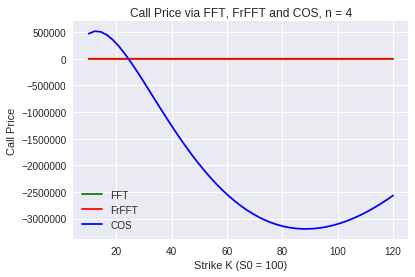

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n = 4')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()

In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 6, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 6, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 6, model = model, OptionType ='Call');

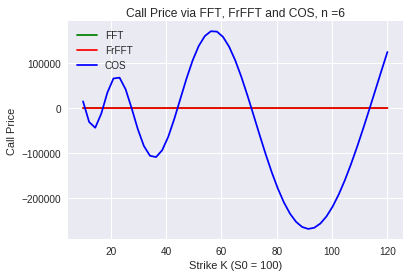

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n =6')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()

In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 8, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 8, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 8, model = model, OptionType ='Call');

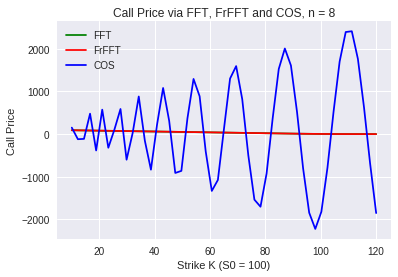

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n = 8')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()

In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 10, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 10, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 10, model = model, OptionType ='Call');

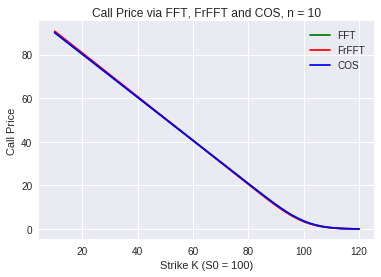

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n = 10')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()

In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 12, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 12, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 12, model = model, OptionType ='Call');

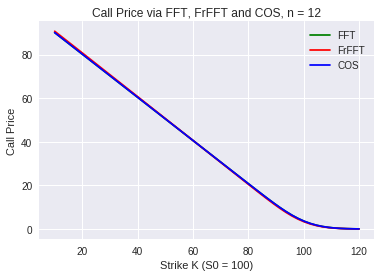

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n = 12')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()

In [0]:
test_price = np.linspace(start = 10, stop = 120, num = 51)
fft_series = np.zeros(51);
frfft_series = np.zeros(51);
cos_series = np.zeros(51);
for i in range(51):
#   print('strike: ' , test_price[i])
  fft_series[i]   = Call_price_FFT( params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, n = 14, model = model)[0];
  frfft_series[i] = Call_price_FrFFT(params = params, S0 = S0, K = test_price[i], r = r, q = q, T = T, alpha = alpha, eta = eta, lmbda = lda,n = 14, model = model)[0];
  cos_series[i]   = Call_price_CoS(  params = params, a = -15, b = 15, S0 = S0, K = test_price[i], r = r, q = q, T = T, n = 14, model = model, OptionType ='Call');

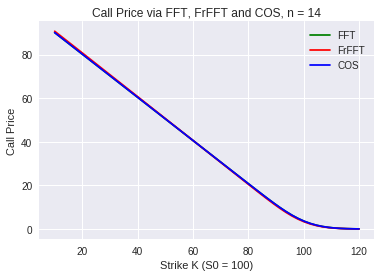

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( test_price,fft_series,label='FFT',c = 'g')
plt.plot( test_price,frfft_series,label='FrFFT',c = 'r')
plt.plot( test_price,cos_series,label='COS',c = 'b')
plt.title('Call Price via FFT, FrFFT and COS, n = 14')
plt.xlabel('Strike K (S0 = 100)')
plt.ylabel('Call Price')
plt.legend()
plt.show()